# Finetuning BART for abstractive text summarisation with fastai2

This notebook is also available as a [Medium post](https://medium.com/curation-corporation/fine-tuning-bart-for-abstractive-text-summarisation-with-fastai2-d7a2ad676a13). The data we are using is our recently open-sourced [Curation Corpus](https://medium.com/curation-corporation/teaching-an-ai-to-abstract-a-new-dataset-for-abstractive-auto-summarisation-5227f546caa8).

A great thing about working in NLP at the moment is being able to park a hard problem for a few weeks and discovering the community making massive amounts of progress on your behalf. I used to be overwhelmed by the challenge of just training a summarisation model to generate plausible looking text without burning through tonnes of cash on GPUs. Then [BertExtAbs](https://github.com/CurationCorp/curation-corpus/blob/master/examples/bertextabs/finetune_bertabs_walkthrough.ipynb) came along and solved that problem. Unfortunately, it still gernerated incoherent sentences sometimes and had a habit of confusing entities in an article. You certainly couldn't trust it to convey the facts of an article reliably.

Enter BART (Bidirectional and Auto-Regressive Transformers). Here we have a model that generates staggeringly good summaries and has a wonderful implementation from [Sam Shleifer at HuggingFace](https://github.com/huggingface/transformers/tree/master/examples/summarization/bart). It's still a work in progress, but after digging around in the Transformers pull requests and with help from [Morgan McGuire's FastHugs notebook](https://github.com/morganmcg1/fasthugs) I have put together this notebook for fine-tuning BART and generating summaries. Feedback welcome!

I should mention that this a big model requiring big inputs. For fine-tuning I've been able to get a batch size of 4 and a maximum sequence length of 512 on an AWS P3.2xlarge (~£4 an hour). There is ongoing work to reduce the memory requirements at HuggingFace and I'll update this accordingly. 

We begin with a bunch of imports and an args object for storing variables we will need. We'll be fine-tuning the model on the Curation Corpus of abstractive text summaries. We load it into a dataframe using Pandas. For more information about how to access this dataset for your own purposes please see our [article introducing the dataset](https://medium.com/curation-corporation/teaching-an-ai-to-abstract-a-new-dataset-for-abstractive-auto-summarisation-5227f546caa8).

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import logging
logging.getLogger().setLevel(100)
from fastprogress import progress_bar
from fastai2.basics import *
from fastai2.data import *
from fastai2.text.all import *
from fastai2.callback.all import *
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import PreTrainedTokenizer, BartTokenizer, BartForConditionalGeneration, BartConfig 
import torch
from torch import nn

Hopefully we will be able to increase our batch size and/or maximum sequence lengths when some pull requests to reduce the model's memory footprint get merged into the Transformers repository

In [3]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
args = Namespace(
    batch_size=8,
    max_seq_len=512,
    data_path="../data/private_dataset.file",
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), # ('cpu'),
    stories_folder='../data/my_own_stories',
    subset=1024,
    test_pct=0.1
)

In [4]:
ds = pd.read_feather(args.data_path).iloc[:args.subset]
ds = ds[ds['summary'] != '']
train_ds, test_ds = train_test_split(ds, test_size=args.test_pct, random_state=42)
valid_ds, test_ds = train_test_split(test_ds, test_size=0.5, random_state=42)

To pass our data to the model in our fastai2 learner object we need a dataloader. To create a dataloader we need a Datasets object, batch size, and device type. To create a Datasets object, we have to pass a few things:
- Our raw data which in our case is a Pandas dataframe
- A list of transforms. Or to be more precise a list containing the list of transforms to perform on our inputs and a list of transforms to perform on our desired outputs. I've defined a transform below that encodes the text using the BART tokenizer. Mostly it will be the encodes class method that gets called by fastai2. However the decodes method can also be useful if you want to reverse the process.
- We will also split our data into training and validation datasets here, using fastai2's RandomSplitter class.

In [5]:
tokenizer = BartTokenizer.from_pretrained('bart-large-cnn', add_prefix_space=True)

I'm still exploring whether it is necessary to pass any of the masks and other ids manually or if it is handled for us. Any advice here would be much appreciated!

In [6]:
class DataTransform(Transform):
    def __init__(self, tokenizer:PreTrainedTokenizer, column:string):
        self.tokenizer = tokenizer
        self.column = column
        
    def encodes(self, inp):  
        tokenized = self.tokenizer.batch_encode_plus(
            [list(inp[self.column])],
            max_length=args.max_seq_len, 
            pad_to_max_length=True, 
            return_tensors='pt'
        )
        return TensorText(tokenized['input_ids']).squeeze()
        
    def decodes(self, encoded):
        decoded = [
            self.tokenizer.decode(
                o, 
                skip_special_tokens=True, 
                clean_up_tokenization_spaces=False
            ) for o in encoded
        ]
        return decoded

In [7]:
x_tfms = [DataTransform(tokenizer, column='text')]
y_tfms = [DataTransform(tokenizer, column='summary')]
dss = Datasets(
    train_ds, 
    tfms=[x_tfms, y_tfms], 
    splits=RandomSplitter(valid_pct=0.1)(range(train_ds.shape[0]))
)

In [8]:
dls = dss.dataloaders(bs=args.batch_size, device=args.device.type)

This function lets us choose between loading the model architecture with Facebook's pre-trained weights, the model architecture with our own weights stored locally, or the model architecture with no pre-training at all.

In [9]:
def load_hf_model(config, pretrained=False, path=None): 
    if pretrained:    
        if path:
            model = BartForConditionalGeneration.from_pretrained(
                "bart-large-cnn", 
                state_dict=torch.load(path, map_location=torch.device(args.device)), 
                config=config
            )
        else: 
            model = BartForConditionalGeneration.from_pretrained("bart-large-cnn", config=config)
    else:
        model = BartForConditionalGeneration()

    return model.to(args.device)

The model will return a lot of different things, but we only want the weights to calculate the loss when training, so we will wrap the model in this class to control what gets passed to the loss function.

In [10]:
class FastaiWrapper(Module):
    def __init__(self):
        self.config = BartConfig(vocab_size=50264, output_past=True)
        self.bart = load_hf_model(config=self.config, pretrained=True)
        
    def forward(self, x):
        output = self.bart(x)[0]
        return output

You can think of seq2seq tasks as a series of attempts to categorise which word should come next. Cross entropy loss is a pretty good loss function for this use case. We want to normalise it by how many non padding words are in each sequence.

In [11]:
class SummarisationLoss(Module):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        
    def forward(self, output, target):
        x = F.log_softmax(output, dim=-1)
        norm = (target != 1).data.sum()
        return self.criterion(x.contiguous().view(-1, x.size(-1)), target.contiguous().view(-1)) / norm

### Training

When fine-tuning the model we will start by just training the top linear layer, then the decoder, and then the encoder (though I'll leave the latter as it is). fastai2 provides an easy way to split the model up into groups with frozen or unfrozen parameters.

I've been experimenting with half precision training. In theory this will save a lot of memory. However, I find my loss quickly becomes a bunch of nans. This may be an issue with HuggingFace's implementation or it may be an issue with my code. I'll update if I work out how to get fp16() working. Do let me know if you have any ideas!

In [12]:
def bart_splitter(model):
    return [
        params(model.bart.model.encoder), 
        params(model.bart.model.decoder),
        params(model.bart.lm_head)
    ]

In [13]:
learn = Learner(
    dls, 
    FastaiWrapper(), 
    loss_func=SummarisationLoss(), 
    opt_func=ranger,
    splitter=bart_splitter
)#.to_fp16()

In [14]:
learn.freeze_to(-1)

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=1.0964781722577754e-06)

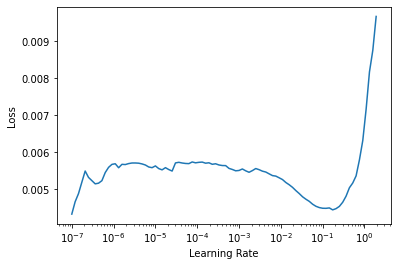

In [15]:
learn.lr_find()

In [16]:
learn.fit_flat_cos(
    1,
    lr=1e-2
)

epoch,train_loss,valid_loss,time
0,0.001305,0.001612,01:47


In [19]:
learn.freeze_to(-2)
learn.dls.train.bs = args.batch_size//2
learn.dls.valid.bs = args.batch_size//2

In [ ]:
learn.lr_find()

In [19]:
learn.fit_flat_cos(
    2,
    lr=1e-4
)

epoch,train_loss,valid_loss,time
0,0.001866,0.001790,01:40
1,0.001834,0.001778,01:41


In [20]:
learn.export('../models/fintuned_bart.pkl')

### Inference

In [14]:
learn = load_learner('../models/fintuned_bart.pkl')

The following code for generating the summaries comes from [Sam Shleifer's example in the Transformers repository](https://github.com/huggingface/transformers/blob/master/examples/summarization/bart/evaluate_cnn.py). 

In [15]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i : i + n]

def generate_summaries(lns, out_file, batch_size=4):
    dec = []
    for batch in progress_bar(list(chunks(lns, batch_size))):
        dct = tokenizer.batch_encode_plus(
            batch, 
            max_length=1024, 
            return_tensors="pt", 
            pad_to_max_length=True
        )
        
        summaries = learn.model.bart.to(args.device).generate(
            input_ids=dct["input_ids"].to(args.device),
            num_beams=4,
            length_penalty=2.0,
            max_length=142,
            min_length=56,
            no_repeat_ngram_size=3,
        )
        
        dec.extend([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summaries])
        
    return dec

In [16]:
lns = [" " + x.rstrip() for x in list(test_ds['text'])[:8]]
bart_sums = generate_summaries(lns, f'{args.stories_folder}/output.txt', batch_size=args.batch_size)

In [17]:
for s in bart_sums[:8]:
    print(s)
    print("***************")

 services provider Petrofac lost out on $10 billion (8 billion pounds) worth of contracts. UK's Serious Fraud Office is investigating the company's dealings in Saudi Arabia and Iraq. Petrofac shares, which have lost nearly half of their value, fell as much as 6.4% on Tuesday.
***************
RhythmOne, an online advertising company, released its third annual Influencer Marketing Benchmarks Report. The report provides insights into Return on Investment (ROI) and best practices based on 76 programs. Over the course of the year, 1R ran influencer marketing campaigns. with 51 brands spanning 18 advertiser categories and employing over 8,700 influencers.
***************
n, a.k.a. thet-a-t-e-t, is the world's biggest, most-watched, and most-loved social network, with more than 1.2. billion users. It's the most popular social network in the world, followed by Facebook, Twitter, YouTube, Instagram, Pinterest, LinkedIn, Facebook Messenger, Skype, Google+ and more. It also has the largest audien